In [1]:
"""Temporary fix for importing modules from parent directory"""

import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from varitop.misc import euler_rule, qconj, q2rm, quat_prod
from varitop.integrator import DelIntegrator as DI
from varitop.opti import Varitop

In [3]:
import sys
import numpy as np
import casadi as cs
import mediapy as media
from tqdm import tqdm
from time import sleep

In [4]:
import pinocchio as pin
import meshcat

In [5]:
from robot_descriptions.bolt_description import URDF_PATH

In [6]:
from darli.model import Model
from darli.model.functional import Functional
from darli.backend import CasadiBackend, Frame, JointType
from darli.backend.liecasadi.so3 import SO3
from darli.state_space import StateSpace
from darli.robots import biped
import casadi as cs

In [7]:
pinmodel, gpinmodel, cpinmodel = pin.buildModelsFromUrdf(URDF_PATH, package_dirs='/home/m8/.cache/robot_descriptions', geometry_types=[pin.GeometryType.VISUAL, pin.GeometryType.COLLISION], root_joint=pin.JointModelFreeFlyer())

In [8]:
pinmodel.nq, pinmodel.nv

(13, 12)

In [9]:
vis = pin.visualize.MeshcatVisualizer(pinmodel, gpinmodel, cpinmodel)

In [10]:
vis.initViewer(loadModel=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [11]:
vis.display(pin.neutral(pinmodel))

In [12]:
print(URDF_PATH)

/home/m8/.cache/robot_descriptions/example-robot-data/robots/bolt_description/robots/bolt.urdf


In [13]:
bodies_map={'torso': 'base_link', 'lf': 'FL_FOOT', 'rf': 'FR_FOOT'}
foot_names = {'lf', 'rf'}

stance_leg = 'lf'
swing_leg = 'rf'
 
darli_model = Functional(CasadiBackend(URDF_PATH, root_joint=JointType.FREE_FLYER))

darli_model.add_body(bodies_map)
for foot in foot_names:
    body = darli_model.body(foot)
    if foot == stance_leg:
        body.add_contact(frame=Frame.LOCAL_WORLD_ALIGNED, contact_type="point")
        body.contact.add_cone(mu=1.0)

darli_model.update_selector(passive_joints=range(6))

In [14]:
di = DI(
    nq = darli_model.nq,
    nu = darli_model.nu,
    lagrangian=darli_model.lagrangian,
    free_body=True
)

In [15]:

ns = 60

opti_problem = cs.Opti()
tf = opti_problem.parameter(1)
tf = 0.3
dt = tf / ns

state = opti_problem.variable(darli_model.nq, ns+1)
q = state[:darli_model.nq, :]
v = None
for i in range(1, ns + 1):
    dqi = (q[:, i] - q[:, i - 1]) / dt
    if v is None:
        v = di.v(q[:, i], dqi)
    else:
        v = cs.horzcat(
            v, di.v(q[:, i], dqi)
        )
u = opti_problem.variable(darli_model.nu, ns)
lmds = opti_problem.variable(1, ns)
stance_grw = opti_problem.variable(darli_model.body(stance_leg).contact.dim, ns)

In [16]:
di.add_force(cs.vertcat(np.zeros(7), di.u))
di.add_constraint(di.q[3:7].T @ di.q[3:7] - 1)

In [17]:
v.shape

(12, 60)

In [18]:
torso_pos = q[:3]
torso_xyzw = q[3:7]

In [19]:
Q_INIT = np.zeros(darli_model.nq)
Q_INIT[2] = 0.45
Q_INIT[6] = 1
vis.display(Q_INIT)

In [20]:
STEP_LENGTH = 0.26
STEP_CLEAREANCE = 0.04

In [21]:

for foot in foot_names:
    INIT_FOOTS = np.array(darli_model.body(foot).position(Q_INIT)).copy()
    foot_pos = darli_model.body(foot).position
    foot_velocity = darli_model.body(foot).linear_velocity.world_aligned
    for i in range(ns+1):
        if foot == stance_leg:
            opti_problem.subject_to(foot_pos(q[:,i]) == INIT_FOOTS)
            cone = darli_model.body(stance_leg).contact.cone.linear()
            if i < ns:
                opti_problem.subject_to(cone@stance_grw[:,i] <= np.zeros(5))
            
    if foot == swing_leg:
        # INTIAL FOOT POSITION
        opti_problem.subject_to(foot_pos(q[:,0])[0] == INIT_FOOTS[0] - STEP_LENGTH/2)
        opti_problem.subject_to(foot_pos(q[:,0])[1:] == INIT_FOOTS[1:])
        opti_problem.subject_to(foot_velocity(q[:,0], v[:,0]) == np.zeros(3))
        # FINAL FOOT POSITION
        opti_problem.subject_to(foot_pos(q[:,-1])[0] == INIT_FOOTS[0] + STEP_LENGTH/2)
        opti_problem.subject_to(foot_pos(q[:,-1])[1:] == INIT_FOOTS[1:])
        opti_problem.subject_to(foot_velocity(q[:,-1], v[:,-1]) == np.zeros(3))
        
        opti_problem.subject_to(foot_pos(q[:,int(ns/2)])[2] >= INIT_FOOTS[2] + STEP_CLEAREANCE)

<!-- TORSO CONSTRAINTS -->

In [22]:
# Y is symmetric 
opti_problem.subject_to(q[1,0] == -q[1,-1])
# opti_problem.subject_to(v[1,0] == -v[1,-1])
for i in range(ns):
    # Z of torso is always bounded
    opti_problem.subject_to(q[2,i] >= 0.3)
    opti_problem.subject_to(q[2,i] <= 0.45)
    # Torso have fixed orientation
    opti_problem.subject_to(q[3:7,i] == np.array([0,0,0,1]))

In [23]:
residual = di.get_residual()

In [24]:
residual

Function(del:(q-1[13],q[13],q+1[13],dt,lambda,u[6])->(DEL Residual[14]) SXFunction)

In [25]:

# position_weight = opti_problem.parameter(1)
position_weight = 0.00001
# orientation_weight = opti_problem.parameter(1)
# # acceleration_weight = opti_problem.parameter(1)
# velocity_weight = opti_problem.parameter(1)
velocity_weight = 0.01
control_weight = 0.0001
force_weight = 0.00001

# control_max = opti_problem.parameter(darli_model.nu)

fd = darli_model.forward_dynamics
cost = 0 

for i in range(1, ns):
    q0 = q[:, i - 1]
    q1 = q[:, i + 0]
    q2 = q[:, i + 1]
    res = residual(q0, q1, q2, dt, lmds[:, i], u[:, i])

    qforce = darli_model.contact_qforce(
        q[:, i],
        stance_grw[:, i],
    )
    qft = qforce[:3]
    qrt = qforce[3:6]
    qrest = qforce[6:]
    qrt = 2 * quat_prod(q[3:7, i], cs.vcat([qrt, 0]))
    qforce = cs.vertcat(qft, qrt, qrest, 0)
    opti_problem.subject_to(
        res + qforce == 0
    )

for i in range(ns):
    # dv_i = fd(q[:,i], v[:,i], u[:, i], stance_grw[:,i])
    # opti_problem.subject_to(v[:, i+1] == v[:,i] + dt*dv_i)
    # opti_problem.subject_to(q[:,i+1] == darli_model.backend.integrate_configuration(q[:,i], v[:,i]*dt))
    # opti_problem.subject_to(q[3:7,i] == np.array([0,0,0,1]))
    cost += position_weight*cs.sumsqr(q[7:,i])*dt
    cost += velocity_weight*cs.sumsqr(v[:,i])*dt
    cost += control_weight*cs.sumsqr(u[:,i])*dt
    cost += force_weight*cs.sumsqr(stance_grw[:,i])*dt
    # cost += acceleration_weight*cs.sumsqr(dv_i)*dt
    # opti_problem.subject_to(opti_problem.bounded(np.zeros(darli_model.nu), u[:, i], control_max))
    # opti_problem.subject_to(q[2, i] >= 0.4)

In [26]:
q_initial = np.full((ns + 1, di.nq), Q_INIT).T
q_initial.shape

(13, 61)

In [27]:
#opti_problem.set_initial(q, q_initial)
opti_problem.minimize(cost)
opti_problem.solver('ipopt')

In [28]:
opti_problem.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    31197
Number of nonzeros in inequality constraint Jacobian.:     1028
Number of nonzeros in Lagrangian Hessian.............:    16431

Total number of variables............................:     1393
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1262
Total number of inequality c

OptiSol(Opti {
  instance #0
  #variables: 4 (nx = 1393)
  #parameters: 0 (np = 0)
  #constraints: 368 (ng = 1683)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

In [29]:
q_solution = opti_problem.value(q)
v_solution = opti_problem.value(v)
u_solution = opti_problem.value(u)
grw_solution = opti_problem.value(stance_grw)

In [60]:
vis.display(q_solution[:, 0])

In [61]:
from time import sleep
sleep(3)
for pw in range(3):
    for i in range(ns + 1):
        vis.display(q_solution[:,i])
        if pw == 0:
            sleep(0.1)
        else:
            sleep(0.01)
    sleep(2)

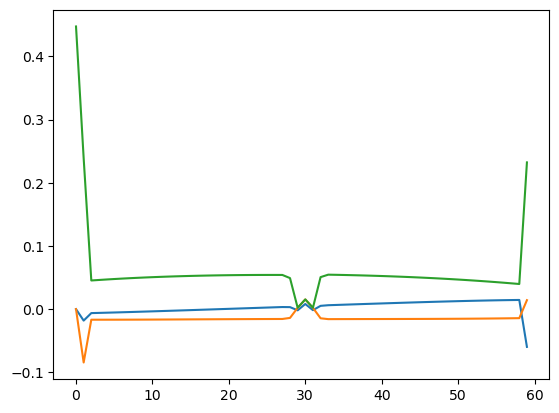

In [31]:

import matplotlib.pyplot as plt

plt.plot(grw_solution.T)
plt.show()

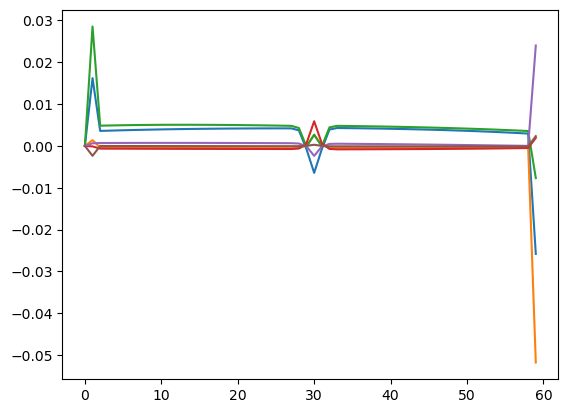

In [32]:
plt.plot(u_solution.T)
plt.show()

In [33]:
foot_xyz_fn = darli_model.body(name='rf').position
foot_xyz_fn

Function(position:(i0[13])->(o0[3]) SXFunction)

In [34]:
foot_xyz = np.array([
    np.array(foot_xyz_fn(q_solution[:, i])) for i in range(ns + 1)
]).T.squeeze()
foot_xyz.shape

(3, 61)

In [35]:
torso_xyz_fn = darli_model.body(name='torso').position
torso_xyz_fn

Function(position:(i0[13])->(o0[3]) SXFunction)

In [36]:
torso_xyz = np.array([
    np.array(torso_xyz_fn(q_solution[:, i])) for i in range(ns + 1)
]).T.squeeze()
torso_xyz.shape

(3, 61)

In [37]:
lf_xyz_fn = darli_model.body(name='lf').position
lf_xyz_fn

Function(position:(i0[13])->(o0[3]) SXFunction)

In [38]:
lf_xyz = np.array([
    np.array(lf_xyz_fn(q_solution[:, i])) for i in range(ns + 1)
]).T.squeeze()
lf_xyz.shape

(3, 61)

In [39]:
v_solution[1, 0] + v_solution[1, -1]

0.13548698079122057

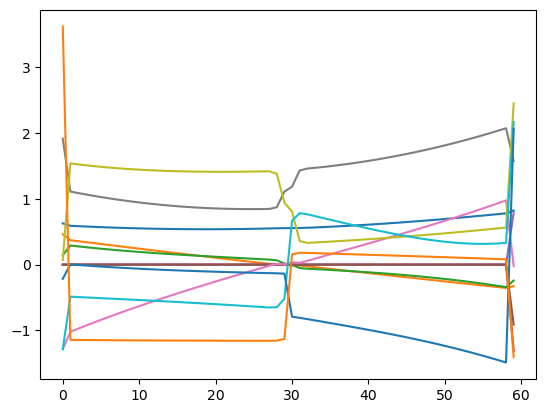

In [40]:
plt.plot(v_solution.T)
plt.show()

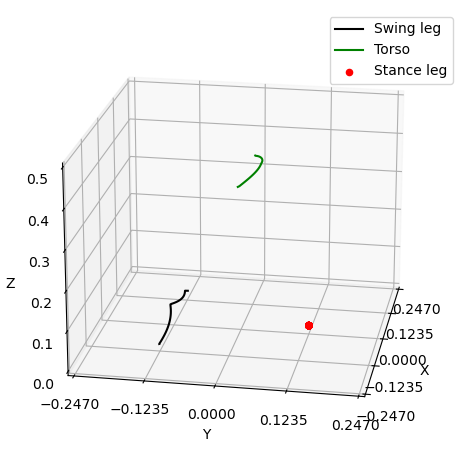

In [41]:
ax = plt.figure().add_subplot(projection='3d')
# Plot a sin curve using the x and y axes.

ax.plot(foot_xyz[0, :], foot_xyz[1, :], foot_xyz[2, :], label='Swing leg', color='black')
ax.plot(torso_xyz[0, :], torso_xyz[1, :], torso_xyz[2, :], label='Torso', color='green')
ax.scatter(lf_xyz[0, :], lf_xyz[1, :], lf_xyz[2, :], label='Stance leg', color='Red')
# ax.scatter(Q_FINAL[0], Q_FINAL[1], Q_FINAL[2], color='red', label='Desired position')
# ax.scatter(Q_INIT[0], Q_INIT[1], Q_INIT[2], color='green', label='Initial position')

# Make legend, set axes limits and labels

xlims = [-2 * foot_xyz[1, 0], 2  * foot_xyz[1, 0]]
ylims = [-2 * lf_xyz[1, 0], 2  * lf_xyz[1, 0]]
zlims = [0, 0.5]

ax.legend()
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_zlim(zlims)

ax.set_xticks(np.linspace(xlims[0], xlims[1], 5))
ax.set_yticks(np.linspace(ylims[0], ylims[1], 5))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=10, roll=0)
plt.tight_layout()
plt.savefig('trajectory.png', dpi=300)
plt.show()

In [42]:
foot_velocity = darli_model.body('rf').linear_velocity.world_aligned
foot_vs = np.array([
    np.array(foot_velocity(q_solution[:, i], v_solution[:, i])) for i in range(ns)
]).T.squeeze()
foot_vs.shape

(3, 60)

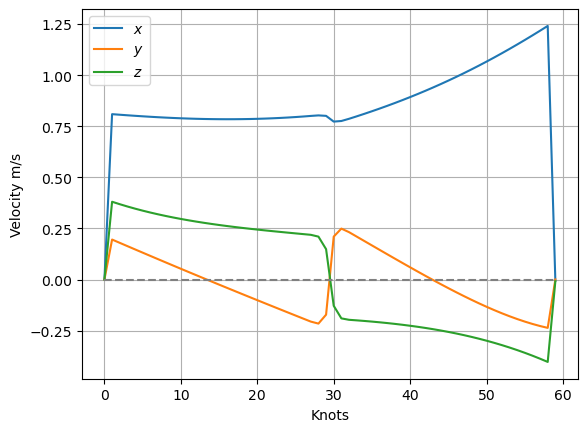

In [43]:
plt.plot(foot_vs.T, label=['$x$', '$y$', '$z$'])
plt.hlines([0], 0, 59, colors='gray', linestyles=['--'])
plt.grid()
plt.legend()
plt.xlabel('Knots')
plt.ylabel('Velocity m/s')
plt.savefig('rf_velocities.png', dpi=300)

In [62]:
import json

In [65]:
q_list = q_solution.tolist()

In [66]:
with open("bolt_q.json", "w") as json_file:
    json.dump(q_list, json_file)